clustering hashtags of videos in metadata

In [35]:
import pandas as pd

### STEP 1: Clean data

In [36]:
hashtag_filter_out = ['fyp', 'foryourpage', 'wow', 'news', 'fypツ', 'fypシ', 
                     'fyi', 'fypシ゚viral', 'foryouuuu', 'trendingtiktok', 'longvideos',
                     'fypppp', 'themoreyouknow', 'didyouknow', 'foryoupage', 'foryou', 'tiktok',
                     'breakingnews', 'topnews', 'viraltiktok', 'fypシ゚viral', 'catchupnews', 'viralvideo',
                     ]

In [37]:
def filtering_hashtag(hashtags):
    """
    filter the hashtags
    """
    output = list(set(hashtags))
    output = [hashtag for hashtag in output if hashtag not in hashtag_filter_out]
    return output

In [38]:
dir_path = "/users/sandyliu/tiktok-news-exposure/" # CHANGE ME!
users = ["26301", "33534", "38129", "48271", "69117", "83721"]

# for one user:
def get_hash_or_sugg(user, to_parse):
    """Grab either the hashtag or suggested words column and clean data."""
    data = pd.read_csv(dir_path + f"3-filter-metadata/news_relevant_videos_{user}.csv")

    if data.empty == False:
        nested_hashtags = []
        for hashtag_list_as_str in data[to_parse]:
            hashtag_list_as_list = hashtag_list_as_str.strip('][').split(", ")
            cleaned_hashtag = [hashtag.strip("'") for hashtag in hashtag_list_as_list]
            nested_hashtags.append(cleaned_hashtag)
        
        flattened_hashtags = [hashtag.strip(" ").lower() for hashlist in nested_hashtags for hashtag in hashlist]
        no_empty_hashtags = list(filter(None, flattened_hashtags))
        no_empty_hashtags = filtering_hashtag(no_empty_hashtags)
        return no_empty_hashtags

get_hash_or_sugg("26301", "hashtags")
#get_hash_or_sugg("26301", "suggested_words")
get_hash_or_sugg("38129", "hashtags")

In [39]:
hashtag_26301 = get_hash_or_sugg("26301", "hashtags")

In [40]:
hashtag_26301 = filtering_hashtag(hashtag_26301)

In [41]:
len(filter_test)

940

### STEP 2: Clustering

In [42]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.cluster import KMeans # pip install scikit-learn
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [43]:
def get_embeddings(to_parse): #for all users
    """Parameter to_parse should either take a value of 'hashtags' or 'suggested_words'."""
    embedding = {}
    for user in users:
        if get_hash_or_sugg(user, to_parse) != None: # if empty file, don't get embeddings
            embedding[user] = embed(get_hash_or_sugg(user, "hashtags"))
    return embedding
    
get_embeddings("hashtags")["26301"]

<tf.Tensor: shape=(932, 512), dtype=float32, numpy=
array([[ 0.0443125 ,  0.02986114,  0.02617949, ..., -0.02955456,
         0.01893775, -0.00893492],
       [ 0.02822169,  0.02857419,  0.04648393, ..., -0.0456822 ,
         0.04814656,  0.05580993],
       [-0.03935093,  0.01385351,  0.06948025, ..., -0.05098186,
         0.04732511, -0.02320975],
       ...,
       [-0.01031195, -0.02378525,  0.06321222, ..., -0.06058952,
         0.05174011, -0.06068309],
       [-0.0767173 , -0.08248989,  0.04139314, ..., -0.03095184,
        -0.0120227 , -0.03054475],
       [ 0.00897577,  0.04949407, -0.01415103, ..., -0.04121582,
         0.06965393,  0.02379157]], dtype=float32)>

In [48]:
def create_clusters(user, to_parse, k=20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(get_embeddings(to_parse)[user])
    
    final_clusters = {}
    for i in range(k):
        data = get_hash_or_sugg(user, to_parse)
        cluster_words = [data[j] for j in range(len(data)) if clusters[j]==i]
        final_clusters[f"cluster{i}"] = cluster_words
    return final_clusters

create_clusters("26301", "hashtags", 20)["cluster1"] # to see the individual words

['powerpoint',
 'science',
 'math',
 'unwritten',
 'biology',
 'grammar',
 'communication',
 'mathematics',
 'ww1',
 'wwi',
 'documentary',
 'aid',
 'sentence',
 'debate',
 'physics',
 'essay']

In [49]:
create_clusters("26301", "hashtags", 20)["cluster2"] 

['economics',
 'money',
 'investing',
 'charges',
 'phd',
 'income',
 'graduation',
 'business',
 'luxury',
 'students',
 'economy',
 'socialism',
 'college',
 'freedom',
 'middleclass',
 'academia',
 'orlandoflorida',
 'tuition',
 'capitalism',
 'homeless',
 'university',
 'war',
 'taxes',
 'finance',
 'inflation',
 'debt',
 'unemployment',
 'royalty',
 'education']

In [50]:
create_clusters("26301", "hashtags", 20)["cluster3"]

['crimescene',
 'fund4good',
 'realestate',
 'hospital',
 'wrestlingtiktok',
 'border',
 'fulltimeinfluencer',
 'connections',
 'foodietiktok',
 'show',
 'hole',
 'drawing',
 'medical',
 'inside',
 'food',
 'echolocation',
 'technology',
 'teddybear',
 'greenscreen',
 'cheese',
 'dancing',
 'bridge',
 'travisalexandercase',
 'oscars2024',
 'accessible',
 'animals',
 'pets',
 'expo',
 'pie',
 'darkweb',
 'sand',
 'pies',
 'cheeseloversoftiktok',
 'capcut',
 'models',
 'sketches',
 'dog',
 'explore',
 'wheelchair',
 'car',
 'accessibility',
 'donation',
 'mobility',
 'health',
 'madelinesoto',
 'shopping',
 'hoops',
 'lead',
 'middleschool',
 'dance',
 'vote']

### STEP 3: Compare K-Means Clustering to Graphical Representation of Words

In [45]:
from sklearn.manifold import TSNE

def calculate_tsne(user, to_parse):
    tsne = TSNE(n_components=2, random_state=42)  
    tsne_results = tsne.fit_transform(get_embeddings(to_parse)[user])

    embed_tsne = pd.DataFrame(tsne_results, columns=['tsne_1', 'tsne_2'])
    embed_tsne[to_parse] = get_hash_or_sugg(user, to_parse)
    return embed_tsne

calculate_tsne("26301", "hashtags")

,tsne_1,tsne_2,hashtags
0,-33.239491,-14.063975,ctscan
1,4.418272,31.657120,edwardian
2,28.112730,1.089247,makeup
3,17.539135,34.431957,minnesota
4,28.149773,2.621535,costume
...,...,...,...
927,-31.891239,-13.607287,readyforcollege
928,-29.833527,7.599711,emilyblunt
929,-14.352122,3.050974,lawstudent
930,15.297918,5.411773,vote


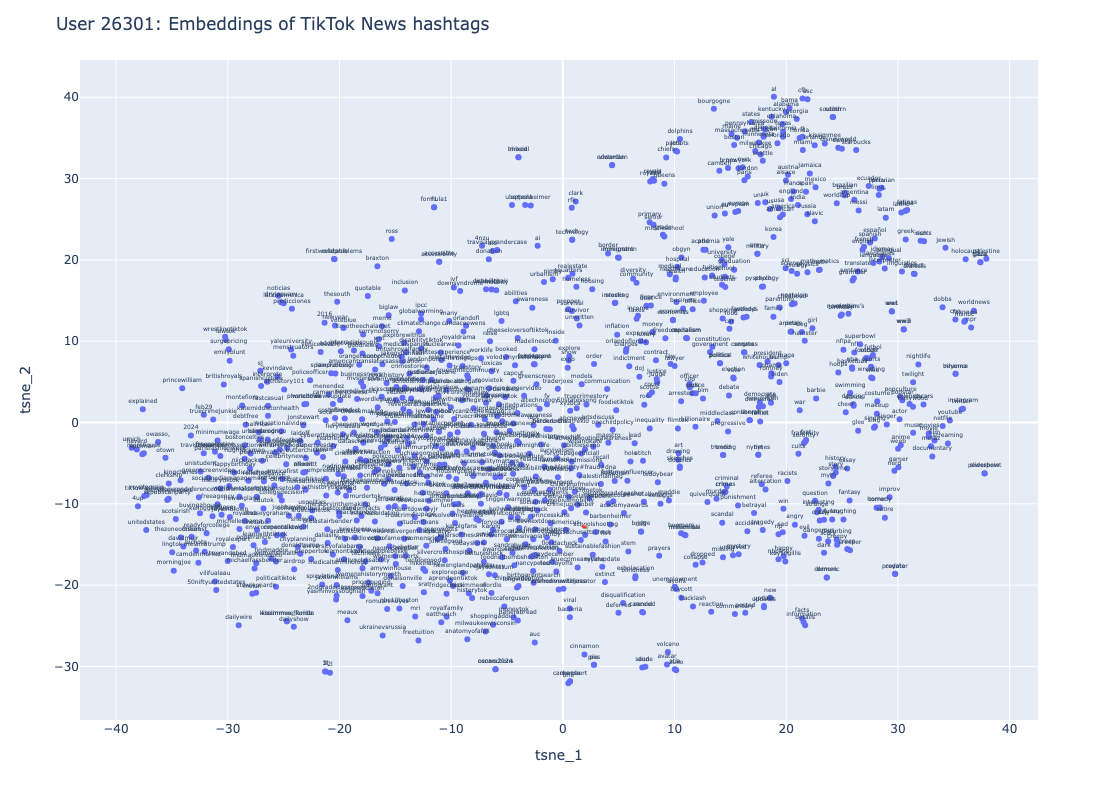

In [51]:
import plotly.express as px

def visualize_tsne(user, to_parse):
    data = calculate_tsne(user, to_parse)
    fig = px.scatter(data, x='tsne_1', y='tsne_2', text=to_parse)
    fig.update_traces(textposition='top center', mode='markers+text', textfont=dict(size=6))
    # Update layout with larger width and height
    fig.update_layout(title=f'User {user}: Embeddings of TikTok News {to_parse}',
                      width=1200,  # Set the width of the figure
                      height=800)  # Set the height of the figure
    fig.show()

visualize_tsne("26301", "hashtags")

## Analysis 1: Hashtags for all Users

## Analysis 2: Suggested words for all Users